In [ ]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

## 一、准备数据
* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


In [3]:
train_df = pd.read_csv('./data/titanic/train.csv')
test_df = pd.read_csv('./data/titanic/test.csv')

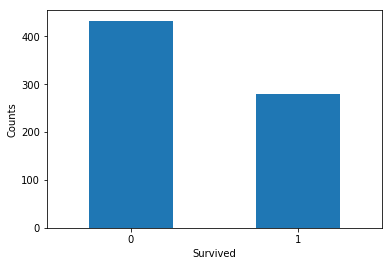

In [4]:
# 查看标签的分布情况
# 内嵌画图
# 存活分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = train_df['Survived'].value_counts().plot(
    kind='bar', rot=0)
ax.set_ylabel('Counts')
ax.set_xlabel('Survived')
plt.show()

In [ ]:
# 年龄分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = train_df['Age'].plot(
    kind='hist', bins=20, color='purple')
ax.set_ylabel('Counts')
ax.set_xlabel('Survived')
plt.show()

In [ ]:
# 年龄和label的相关性
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = train_df.query('Survived == 0')['Age'].plot(kind='density')
ax = train_df.query('Survived == 1')['Age'].plot(kind='density')
ax.legend(['Survived==0', 'Survived==1'])
ax.set_ylabel('Density')
ax.set_xlabel('Age')

plt.show()

In [4]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


In [5]:
# 数据预处理
def preprocessing(data: pd.DataFrame):
    result = pd.DataFrame()
    
    # Pclass 票的种类 进行 one-hot编码
    pclass = pd.get_dummies(data['Pclass'])    # 对数据进行one hot 编码
    pclass.columns = ['Pcalss_' + str(x) for x in pclass.columns]
    result = pd.concat([result, pclass], axis=1)
    
    # Sex: 性别
    sex = pd.get_dummies(data['Sex'])
    result = pd.concat([result, sex], axis=1)
    
    # Age
    result['Age'] = data['Age'].fillna(0)    # 使用0填充缺失值
    result['Age_null'] = pd.isna(data['Age']).astype('int32')  # 新增辅助特征
    
    # Sibsp, Parch, Fare
    result['SibSp'] = data['SibSp']
    result['Parch'] = data['Parch']
    result['Fare'] = data['Fare']
    
    # Cabin 船舱
    result['Cabin_null'] = pd.isna(data['Cabin']).astype('int32')
    
    # Embarked 港口
    embarked = pd.get_dummies(data['Embarked'], dummy_na=True)
    embarked.columns = ['Embarked_' + str(x) for x in embarked.columns]
    result = pd.concat([result, embarked], axis=1)
    
    return result


x_train = preprocessing(train_df).values
y_train = train_df[['Survived']].values

x_test = preprocessing(test_df).values
y_test = test_df[['Survived']].values


print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


In [6]:
# 将数据集使用pytorch封装为可迭代的数据管道
dl_train = DataLoader(
    TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),
    shuffle=True, batch_size=8
)

dl_valid = DataLoader(
    TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()),
    shuffle=False, batch_size=8
)

In [ ]:
for featurs, labels in dl_train:
    print(featurs, labels)
    break

## 构建模型
pytorch 通常有三种方式构建模型：
* 使用 nn.Sequential 按层顺序构建模型
* 继承 nn.Module 基类构建自定义模型
* 继承 nn.Module 基类构建模型并辅助应用模型容器进行封装

In [7]:
# 使用nn.Sequential按顺序构建模型
def create_net():
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(15, 20))  # 全连接层,输入15个特征，输出20个特征
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear2", nn.Linear(20, 15))  # 
    net.add_module("relu2", nn.ReLU())
    net.add_module("linear3", nn.Linear(15, 1))
    net.add_module("sigmoid", nn.Sigmoid())
    return net
    
net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
from sklearn.metrics import accuracy_score

In [9]:
loss_func = nn.BCELoss()    # 损失函数
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_ture: \
accuracy_score(y_ture.data.numpy(), y_pred.data.numpy() > 0.5)
metric_name = 'accuracy'

In [12]:
epochs = 10
log_step_freq = 30
history = pd.DataFrame(columns=
["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training ...')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1, epochs + 1):
    
    # 1. 训练循环
    net.train()
    loss_sum = .0
    metric_sum = .0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度归零
        optimizer.zero_grad()
        
        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别的日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 2. 验证循环
    net.eval()
    val_loss_sum = .0
    val_metric_sum = .0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            val_metric = metric_func(predictions, labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
        
    # 3. 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    history.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training ...
================================================================================2020-10-16 16:07:37
[step = 30] loss: 0.444, accuracy: 0.812
[step = 60] loss: 0.467, accuracy: 0.798

EPOCH = 1, loss = 0.449,accuracy  = 0.812, val_loss = 0.462, val_accuracy = 0.783

================================================================================2020-10-16 16:07:37
[step = 30] loss: 0.459, accuracy: 0.787
[step = 60] loss: 0.451, accuracy: 0.792

EPOCH = 2, loss = 0.464,accuracy  = 0.792, val_loss = 0.491, val_accuracy = 0.761

================================================================================2020-10-16 16:07:37
[step = 30] loss: 0.441, accuracy: 0.833
[step = 60] loss: 0.482, accuracy: 0.796

EPOCH = 3, loss = 0.470,accuracy  = 0.799, val_loss = 0.450, val_accuracy = 0.788

================================================================================2020-10-16 16:07:37
[step = 30] loss: 0.481, accuracy: 0.783
[step = 60] loss: 0.448, accuracy: 0.810



In [13]:
history

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.449438,0.811798,0.462010,0.782609
1,2.0,0.464359,0.792135,0.491477,0.760870
2,3.0,0.469832,0.799157,0.450143,0.788043
3,4.0,0.453279,0.801966,0.415686,0.809783
4,5.0,0.463628,0.803371,0.518228,0.757246
5,6.0,0.457430,0.800562,0.436796,0.836957
6,7.0,0.463886,0.807584,0.488497,0.777174
7,8.0,0.446345,0.804775,0.409231,0.826087
8,9.0,0.436837,0.816011,0.531698,0.717391
9,10.0,0.477597,0.776685,0.427853,0.798913


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history[metric]
    val_metrics = history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

### 使用模型

In [18]:
# 预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.2937],
        [0.5396],
        [0.4121],
        [0.7580],
        [0.5455],
        [0.8299],
        [0.1833],
        [0.8605],
        [0.7580],
        [0.1948]])

In [19]:
# 预测类别
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [21]:
accuracy_score(y_test[:10], y_pred.numpy())

0.9

### 保存加载模型
* 保存模型参数
* 保存完整模型

In [22]:
# 仅保存模型参数
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [24]:
torch.save(net.state_dict(), './model/1_net_parameter.pkl')

# 加载模型
net_clone = create_net()
net_clone.load_state_dict(torch.load('./model/1_net_parameter.pkl'))

# 使用加载的模型预测
y_pred_probs = net_clone(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.2937],
        [0.5396],
        [0.4121],
        [0.7580],
        [0.5455],
        [0.8299],
        [0.1833],
        [0.8605],
        [0.7580],
        [0.1948]])

In [25]:
# 保存完整模型
torch.save(net, './model/1_net_model.pkl')
net_loaded = torch.load('./model/1_net_model.pkl')
y_pred_probs = net_loaded(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid.

tensor([[0.2937],
        [0.5396],
        [0.4121],
        [0.7580],
        [0.5455],
        [0.8299],
        [0.1833],
        [0.8605],
        [0.7580],
        [0.1948]])